In [ ]:
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.ensemble import RandomForestRegressor, AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVR
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import StandardScaler
from xgboost import XGBRegressor
import numpy as np
import pandas as pd
import time
import matplotlib.pyplot as plt

/var/folders/_t/mfgk4xxn1hb8w2n3w5x65snw0000gp/T/ipykernel_34902/3943002136.py:1: DtypeWarning: Columns (5,46) have mixed types. Specify dtype option on import or set low_memory=False.
  df = pd.read_csv("df_working.csv")


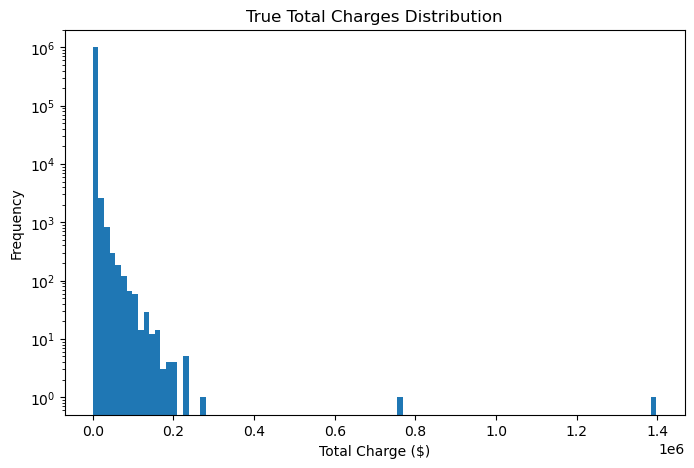

      DUID  PID    DUPERSID           EVNTIDX  EVENTRN FFEEIDX  PANEL  \
0  2460002  101  2460002101  2460002101008301        8     NaN     24   
1  2460002  101  2460002101  2460002101009001        9     NaN     24   
2  2460006  101  2460006101  2460006101009401        7     NaN     24   
3  2460006  101  2460006101  2460006101010501        8     NaN     24   
4  2460006  101  2460006101  2460006101010601        8     NaN     24   

   MPCELIG  MPCDATA  OBDATEYR  ...  FFBEF21  FFTOT22  OBXP21X  FFBEF20  \
0        1        1      2022  ...      NaN      NaN      NaN      NaN   
1        2        2      2022  ...      NaN      NaN      NaN      NaN   
2        1        2      2022  ...      NaN      NaN      NaN      NaN   
3        1        2      2022  ...      NaN      NaN      NaN      NaN   
4        1        2      2022  ...      NaN      NaN      NaN      NaN   

   FFTOT21  OBXP20X  FFBEF19  FFTOT20  OBXP19X  COST_COVERED  
0      NaN      NaN      NaN      NaN      NaN       

In [2]:
df = pd.read_csv("df_working.csv")
#df = df.sample(n=500000, random_state=42)

plt.figure(figsize=(8, 5))
plt.hist(df['total_charge'], bins=100)
plt.title('True Total Charges Distribution')
plt.xlabel('Total Charge ($)')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()

print(df.head())

In [ ]:
# Models to try
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(),
    'Lasso Regression': Lasso(),
    #'Random Forest': RandomForestRegressor(),
    # 'Decision Tree': DecisionTreeRegressor(),
    'AdaBoost': AdaBoostRegressor(),
    'XGBoost': XGBRegressor(verbosity=0), 
    #'Support Vector': SVR()
}

print(df['TELEHEALTHFLAG'])

In [3]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder
import numpy as np

# Define columns
feature_cols = [
    'VISITTYPE', 'VSTCTGRY', 'DOCATLOC', 'DRSPLTY_M18',
    'MEDPTYPE_M18', 'SEEDOC_M18', 'SURGPROC', 'MEDPRESC', 'TELEHEALTHFLAG',
    'LABTEST_M18', 'XRAYS_M18', 'MRI_M18', 'EKG_M18',
    'OBDATEYR', 'OBDATEMM', 'insurance'
]

binary_cols = [
    'DOCATLOC', 'SEEDOC_M18', 'SURGPROC', 'MEDPRESC', 'TELEHEALTHFLAG', 
    'LABTEST_M18', 'XRAYS_M18', 'MRI_M18', 'EKG_M18'
]

# Fill NA and convert to string initially
df[feature_cols] = df[feature_cols].fillna('Missing')
df[feature_cols] = df[feature_cols].astype(str)


# Map binary features to numeric
for col in binary_cols:
    df[col] = df[col].map({'1': 1, '2.0': 0, 'Missing': '2.0'})

# Build model dataframe
df_model = df[feature_cols + ['total_charge', 'out_of_pocket', 'COST_COVERED']]
df_model['log_total_charge'] = np.log1p(df_model['total_charge'])

# Define inputs and targets
X = df_model[feature_cols]

targets = {
    'Total Cost': df_model['total_charge'],
    'Out-of-Pocket': df_model['out_of_pocket'],
    'Cost Covered': df_model['COST_COVERED']
}

# Identify categorical columns = object types EXCLUDING binary numeric cols
categorical_cols = list(set(X.select_dtypes(include='object').columns) - set(binary_cols))

# Preprocessor: Categorical = impute + encode, pass binary and other numerics through
# --- Categorical preprocessing ---
cat_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore'))
])

# --- Numeric (binary) preprocessing ---
num_pipeline = Pipeline(steps=[
    ('imputer', SimpleImputer(strategy='most_frequent'))  # fill NaNs in binary
])

# --- Final column transformer ---
preprocessor = ColumnTransformer(
    transformers=[
        ('cat', cat_pipeline, categorical_cols),
        ('num', num_pipeline, binary_cols)
    ],
    remainder='passthrough'  # everything else (e.g., year/month) passes through
)

print(df_model[feature_cols + ['total_charge', 'out_of_pocket', 'COST_COVERED']].head())

/var/folders/_t/mfgk4xxn1hb8w2n3w5x65snw0000gp/T/ipykernel_34902/1129453235.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_model['log_total_charge'] = np.log1p(df_model['total_charge'])


  VISITTYPE VSTCTGRY DOCATLOC DRSPLTY_M18 MEDPTYPE_M18 SEEDOC_M18 SURGPROC  \
0   Missing      1.0      2.0         8.0      Missing        NaN        0   
1   Missing      2.0        0     Missing          8.0          0        0   
2   Missing      1.0      2.0        14.0      Missing        NaN        0   
3   Missing      2.0      2.0        14.0      Missing        NaN        0   
4   Missing      2.0      2.0        14.0      Missing        NaN        0   

  MEDPRESC TELEHEALTHFLAG LABTEST_M18 XRAYS_M18 MRI_M18 EKG_M18 OBDATEYR  \
0      NaN              0         NaN         0       0       0     2022   
1        0              0         NaN         0       0       0     2022   
2        0              0           0         0       0       0     2022   
3      2.0              0           0         0       0       0     2022   
4      2.0              0           0         0       0       0     2022   

  OBDATEMM                    insurance  total_charge  out_of_pocket  \
0 

In [ ]:
# Check missing values in target variables
print("Missing values in targets:")
print(f"total_charge: {df_model['total_charge'].isna().sum()} missing")
print(f"out_of_pocket: {df_model['out_of_pocket'].isna().sum()} missing")
print(f"COST_COVERED: {df_model['COST_COVERED'].isna().sum()} missing")

In [ ]:
# Fix the calendar feature conversion error
# Replace 'Missing' with np.nan first, then convert to numeric
df_model['visit_month'] = pd.to_numeric(df_model['OBDATEMM'].replace('Missing', np.nan), errors='coerce')
df_model['visit_year'] = pd.to_numeric(df_model['OBDATEYR'].replace('Missing', np.nan), errors='coerce')
df_model['visit_quarter'] = df_model['visit_month'].apply(lambda x: (x-1)//3 + 1 if not pd.isna(x) else np.nan)

# For categorical interaction features, keep them as strings
df_model['speciality_insurance'] = df_model['DRSPLTY_M18'].astype(str) + '_' + df_model['insurance'].astype(str)
df_model['visit_type_category'] = df_model['VISITTYPE'].astype(str) + '_' + df_model['VSTCTGRY'].astype(str)

# Test complexity - convert to numeric first
for test_col in ['LABTEST_M18', 'XRAYS_M18', 'MRI_M18', 'EKG_M18']:
    # These should already be converted to 0/1 with np.nan from your binary processing
    # But let's make sure
    if df_model[test_col].dtype == 'object':
        df_model[test_col] = pd.to_numeric(df_model[test_col].replace('Missing', np.nan), errors='coerce')

# Now create test complexity score
df_model['test_complexity'] = (df_model['LABTEST_M18'].fillna(0) + 
                         df_model['XRAYS_M18'].fillna(0) + 
                         (df_model['MRI_M18'].fillna(0) * 3) +  # MRIs are more expensive
                         df_model['EKG_M18'].fillna(0))

# Provider/facility type indicators
df_model['is_hospital'] = df_model['VSTCTGRY'].isin(['1.0']).astype(int)
df_model['is_outpatient'] = df_model['VSTCTGRY'].isin(['2.0']).astype(int) 
df_model['is_office'] = df_model['VSTCTGRY'].isin(['3.0']).astype(int)
df_model['is_emergency'] = df_model['VSTCTGRY'].isin(['4.0']).astype(int)

# Primary care vs. specialist
df_model['is_primary_care'] = df_model['DRSPLTY_M18'].isin(['1.0', '3.0']).astype(int)
df_model['is_specialist'] = (~df_model['DRSPLTY_M18'].isin(['1.0', '3.0', 'Missing'])).astype(int)

# Service combinations
df_model['surgical_with_imaging'] = ((df_model['SURGPROC'] == 1) & 
                                   ((df_model['XRAYS_M18'] == 1) | 
                                    (df_model['MRI_M18'] == 1))).astype(int)

# Visit complexity 
df_model['high_complexity'] = ((df_model['test_complexity'] > 1) | 
                             (df_model['SURGPROC'] == 1)).astype(int)

# Insurance-based features
df_model['has_insurance'] = (df_model['insurance'] != 'Uninsured').astype(int)

df_model['procedure_count'] = (df_model['LABTEST_M18'].fillna(0).astype(bool).astype(int) + 
                         df_model['XRAYS_M18'].fillna(0).astype(bool).astype(int) + 
                         df_model['MRI_M18'].fillna(0).astype(bool).astype(int) + 
                         df_model['EKG_M18'].fillna(0).astype(bool).astype(int) +
                         df_model['SURGPROC'].fillna(0).astype(bool).astype(int))

# Special visits are often more expensive
df_model['is_specialist'] = (~df_model['DRSPLTY_M18'].isin(['Missing', '1.0', '3.0'])).astype(int)
 
# Prescription indicator
df_model['has_prescription'] = (df_model['MEDPRESC'] == 1).astype(int)

# Define new feature columns list
feature_cols_enhanced = feature_cols + [
    'visit_month', 'visit_year', 'visit_quarter', 
    'test_complexity', 'procedure_count', 'is_specialist',
    'has_prescription', 'is_hospital', 'is_outpatient', 'is_office', 'is_emergency', 
    'is_primary_care', 'surgical_with_imaging', 'high_complexity', 'has_insurance'
]

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/var/folders/_t/mfgk4xxn1hb8w2n3w5x65snw0000gp/T/ipykernel_34902/462076283.py:79: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  X_reg.drop(columns=low_var_cols, inplace=True)
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: Future

Fitting 3 folds for each of 10 candidates, totalling 30 fits
[CV] END regressor__depth=4, regressor__iterations=1000, regressor__l2_leaf_reg=7, regressor__learning_rate=0.01; total time=   0.3s
[CV] END regressor__depth=4, regressor__iterations=1000, regressor__l2_leaf_reg=7, regressor__learning_rate=0.01; total time=   0.3s
[CV] END regressor__depth=4, regressor__iterations=1000, regressor__l2_leaf_reg=5, regressor__learning_rate=0.01; total time=   0.2s
[CV] END regressor__depth=4, regressor__iterations=1000, regressor__l2_leaf_reg=5, regressor__learning_rate=0.01; total time=   0.3s
[CV] END regressor__depth=4, regressor__iterations=1000, regressor__l2_leaf_reg=3, regressor__learning_rate=0.1; total time=   0.3s
[CV] END regressor__depth=4, regressor__iterations=1000, regressor__l2_leaf_reg=1, regressor__learning_rate=0.01; total time=   0.3s
[CV] END regressor__depth=4, regressor__iterations=1000, regressor__l2_leaf_reg=5, regressor__learning_rate=0.01; total time=   0.3s
[CV] END 

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1

[CV] END regressor__depth=4, regressor__iterations=1000, regressor__l2_leaf_reg=1, regressor__learning_rate=0.01; total time=   0.3s
[CV] END regressor__depth=6, regressor__iterations=500, regressor__l2_leaf_reg=3, regressor__learning_rate=0.1; total time=   0.4s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END regressor__depth=6, regressor__iterations=500, regressor__l2_leaf_reg=3, regressor__learning_rate=0.1; total time=   0.4s
[CV] END regressor__depth=6, regressor__iterations=500, regressor__l2_leaf_reg=3, regressor__learning_rate=0.1; total time=   0.4s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END regressor__depth=4, regressor__iterations=1000, regressor__l2_leaf_reg=3, regressor__learning_rate=0.05; total time=   0.2s
[CV] END regressor__depth=4, regressor__iterations=1000, regressor__l2_leaf_reg=3, regressor__learning_rate=0.05; total time=   0.2s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END regressor__depth=4, regressor__iterations=1000, regressor__l2_leaf_reg=3, regressor__learning_rate=0.05; total time=   0.3s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END regressor__depth=8, regressor__iterations=500, regressor__l2_leaf_reg=7, regressor__learning_rate=0.1; total time=   1.2s
[CV] END regressor__depth=8, regressor__iterations=500, regressor__l2_leaf_reg=7, regressor__learning_rate=0.1; total time=   1.1s


/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


[CV] END regressor__depth=6, regressor__iterations=1000, regressor__l2_leaf_reg=3, regressor__learning_rate=0.05; total time=   0.8s
[CV] END regressor__depth=8, regressor__iterations=500, regressor__l2_leaf_reg=7, regressor__learning_rate=0.1; total time=   1.2s
[CV] END regressor__depth=8, regressor__iterations=1000, regressor__l2_leaf_reg=1, regressor__learning_rate=0.01; total time=   1.6s
[CV] END regressor__depth=8, regressor__iterations=1000, regressor__l2_leaf_reg=1, regressor__learning_rate=0.01; total time=   1.7s
[CV] END regressor__depth=8, regressor__iterations=1000, regressor__l2_leaf_reg=1, regressor__learning_rate=0.01; total time=   1.7s
[CV] END regressor__depth=6, regressor__iterations=1000, regressor__l2_leaf_reg=3, regressor__learning_rate=0.05; total time=   0.8s
[CV] END regressor__depth=6, regressor__iterations=1000, regressor__l2_leaf_reg=3, regressor__learning_rate=0.05; total time=   0.7s
[CV] END regressor__depth=8, regressor__iterations=1000, regressor__l2_

/opt/anaconda3/lib/python3.11/site-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


Best parameters: {'regressor__learning_rate': 0.01, 'regressor__l2_leaf_reg': 1, 'regressor__iterations': 1000, 'regressor__depth': 4}
RMSE: 3463.48, R²: 0.0355


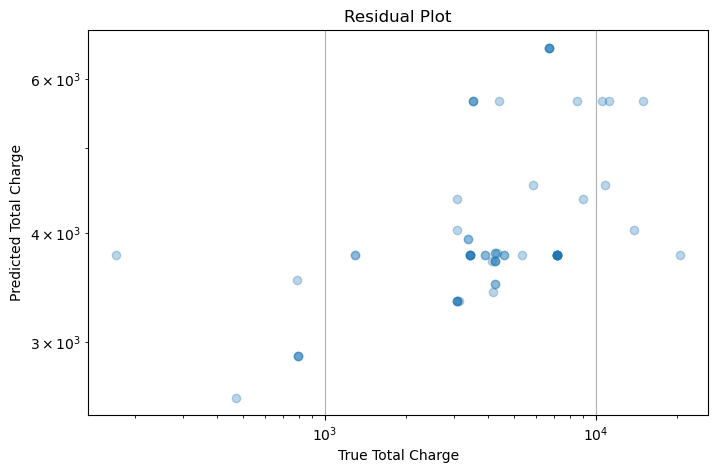

In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.ensemble import HistGradientBoostingClassifier
from catboost import CatBoostRegressor

# --- Feature Setup ---
feature_cols = [
    'VISITTYPE', 'VSTCTGRY', 'DOCATLOC', 'DRSPLTY_M18',
    'MEDPTYPE_M18', 'SEEDOC_M18', 'SURGPROC', 'MEDPRESC', 'TELEHEALTHFLAG',
    'LABTEST_M18', 'XRAYS_M18', 'MRI_M18', 'EKG_M18',
    'OBDATEYR', 'OBDATEMM', 'insurance'
]

binary_cols = [
    'DOCATLOC', 'SEEDOC_M18', 'SURGPROC', 'MEDPRESC', 'TELEHEALTHFLAG', 
    'LABTEST_M18', 'XRAYS_M18', 'MRI_M18', 'EKG_M18'
]

# --- Clean binary and categorical features ---
for col in binary_cols:
    df[col] = pd.to_numeric(df[col], errors='coerce')
    df[col] = df[col].map({1.0: 1, 2.0: 0})

categorical_cols = list(set(feature_cols) - set(binary_cols))
df[categorical_cols] = df[categorical_cols].fillna('Missing').astype(str)

# --- Feature Engineering ---
df['service_complexity'] = df[['LABTEST_M18', 'XRAYS_M18', 'MRI_M18', 'EKG_M18', 'SURGPROC']].sum(axis=1, skipna=True)
df['did_any_test'] = (df['service_complexity'] > 0).astype(int)
df['is_medicare'] = df['insurance'].str.contains('Medicare', na=False).astype(int)

# --- Filter valid target ---
df_model = df[feature_cols + ['service_complexity', 'did_any_test', 'is_medicare', 'total_charge']].copy()
df_model = df_model[~df_model['total_charge'].isna()]
df_model['log_total_charge'] = np.log1p(df_model['total_charge'])
high_cost_cutoff = df_model['total_charge'].quantile(0.95)
df_model['high_cost_flag'] = (df_model['total_charge'] > high_cost_cutoff).astype(int)

# --- Stage 1: Classification ---
X_class = df_model[feature_cols + ['service_complexity', 'did_any_test', 'is_medicare']]
y_class = df_model['high_cost_flag']

categorical_features = list(set(X_class.select_dtypes(include='object').columns))
cat_pipe = Pipeline([
    ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
    ('encoder', OneHotEncoder(handle_unknown='ignore', sparse=False))
])

class_preprocessor = ColumnTransformer([
    ('cat', cat_pipe, categorical_features)
], remainder='passthrough')

clf = Pipeline([
    ('preprocessor', class_preprocessor),
    ('classifier', HistGradientBoostingClassifier(random_state=42))
])

X_train_clf, X_test_clf, y_train_clf, y_test_clf = train_test_split(X_class, y_class, test_size=0.2, random_state=42)
clf.fit(X_train_clf, y_train_clf)

# --- Predict probabilities and inject into regression ---
df_model['high_cost_proba'] = clf.predict_proba(X_class)[:, 1]
df_model['high_cost_flag'] = (df_model['high_cost_proba'] >= 0.5).astype(int)

# --- Stage 2: Regression on high-cost only ---
df_reg = df_model[df_model['high_cost_flag'] == 1].copy()
X_reg = df_reg[feature_cols + ['service_complexity', 'did_any_test', 'is_medicare', 'high_cost_proba']]
y_reg = df_reg['log_total_charge']

# Drop low-variance features
low_var_cols = X_reg.var(numeric_only=True)[lambda x: x < 1e-8].index.tolist()
X_reg.drop(columns=low_var_cols, inplace=True)

reg_cat_features = list(set(X_reg.select_dtypes(include='object').columns))
numeric_features = list(set(X_reg.columns) - set(reg_cat_features))

reg_preprocessor = ColumnTransformer([
    ('cat', cat_pipe, reg_cat_features),
    ('num', make_pipeline(SimpleImputer(strategy='median'), StandardScaler()), numeric_features)
])

reg_pipeline = Pipeline([
    ('preprocessor', reg_preprocessor),
    ('regressor', CatBoostRegressor(verbose=False))
])

X_train_reg, X_test_reg, y_train_reg, y_test_reg = train_test_split(X_reg, y_reg, test_size=0.2, random_state=42)

param_grid = {
    'regressor__iterations': [500, 1000],
    'regressor__learning_rate': [0.01, 0.05, 0.1],
    'regressor__depth': [4, 6, 8],
    'regressor__l2_leaf_reg': [1, 3, 5, 7]
}

search = RandomizedSearchCV(
    reg_pipeline,
    param_grid,
    n_iter=10,
    cv=3,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2,
    error_score='raise'
)

search.fit(X_train_reg, y_train_reg)

best_model = search.best_estimator_
y_pred_log = best_model.predict(X_test_reg)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test_reg)

rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)

print(f"Best parameters: {search.best_params_}")
print(f"RMSE: {rmse:.2f}, R²: {r2:.4f}")

# --- Residual Plot ---
plt.figure(figsize=(8, 5))
plt.scatter(y_true, y_pred, alpha=0.3)
plt.xscale('log')
plt.yscale('log')
plt.title('Residual Plot')
plt.xlabel('True Total Charge')
plt.ylabel('Predicted Total Charge')
plt.grid(True)
plt.show()

Final Model RMSE: 3006.26, R²: -0.0233


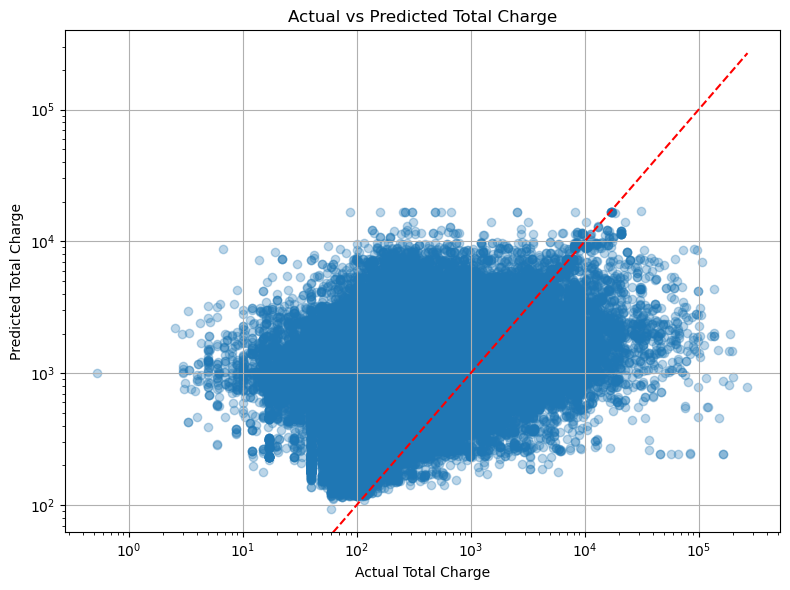

In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from catboost import CatBoostClassifier, CatBoostRegressor

# --- Feature Engineering ---
def engineer_features(df, binary_cols, categorical_cols):
    df_proc = df.copy()
    for col in binary_cols:
        df_proc[col] = pd.to_numeric(df_proc[col], errors='coerce')
        df_proc[col] = df_proc[col].map({1.0: 1, 2.0: 0})

    for col in categorical_cols:
        df_proc[col] = df_proc[col].fillna('Missing').astype(str)

    df_proc['service_complexity'] = df_proc[['LABTEST_M18', 'XRAYS_M18', 'MRI_M18', 'EKG_M18', 'SURGPROC']].sum(axis=1, min_count=1)
    df_proc['imaging_intensity'] = ((df_proc['XRAYS_M18'] == 1) * 1 + (df_proc['MRI_M18'] == 1) * 5 + (df_proc['EKG_M18'] == 1) * 2)
    df_proc['did_any_test'] = (df_proc['service_complexity'] > 0).astype(int)
    df_proc['is_complex_visit'] = ((df_proc['service_complexity'] > 1) & (df_proc['SURGPROC'] == 1)).astype(int)
    df_proc['is_medicare'] = df_proc['insurance'].str.contains('Medicare', na=False).astype(int)
    df_proc['is_private'] = df_proc['insurance'].str.contains('Private', na=False).astype(int)
    df_proc['is_medicaid'] = df_proc['insurance'].str.contains('Medicaid', na=False).astype(int)
    df_proc['specialist_visit'] = ((df_proc['DRSPLTY_M18'] != 'primary care') & (df_proc['DRSPLTY_M18'] != 'Missing')).astype(int)
    df_proc['visit_quarter'] = pd.to_numeric(df_proc['OBDATEMM'], errors='coerce').apply(lambda x: (x - 1) // 3 + 1 if not pd.isna(x) else np.nan)
    df_proc['is_telehealth'] = df_proc['TELEHEALTHFLAG'].fillna(0)
    return df_proc

# --- Main Execution ---
def main():
    feature_cols = [
        'VISITTYPE', 'VSTCTGRY', 'DOCATLOC', 'DRSPLTY_M18',
        'MEDPTYPE_M18', 'SEEDOC_M18', 'SURGPROC', 'MEDPRESC', 'TELEHEALTHFLAG',
        'LABTEST_M18', 'XRAYS_M18', 'MRI_M18', 'EKG_M18',
        'OBDATEYR', 'OBDATEMM', 'insurance'
    ]
    binary_cols = ['DOCATLOC', 'SEEDOC_M18', 'SURGPROC', 'MEDPRESC', 'TELEHEALTHFLAG', 'LABTEST_M18', 'XRAYS_M18', 'MRI_M18', 'EKG_M18']
    categorical_cols = list(set(feature_cols) - set(binary_cols))

    df_processed = engineer_features(df, binary_cols, categorical_cols)
    df_model = df_processed.dropna(subset=['total_charge']).copy()
    df_model['log_total_charge'] = np.log1p(df_model['total_charge'])
    high_cost_cutoff = df_model['total_charge'].quantile(0.9)
    df_model['high_cost_flag'] = (df_model['total_charge'] > high_cost_cutoff).astype(int)

    feature_set = feature_cols + [
        'service_complexity', 'imaging_intensity', 'did_any_test', 'is_complex_visit',
        'is_medicare', 'is_private', 'is_medicaid', 'specialist_visit', 'visit_quarter', 'is_telehealth'
    ]

    X = df_model[feature_set].copy()
    y = df_model['log_total_charge']
    y_class = df_model['high_cost_flag']
    y_raw = df_model['total_charge']

    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
    y_class_train = y_class.loc[X_train.index]
    y_class_test = y_class.loc[X_test.index]
    y_raw_test = y_raw.loc[X_test.index]

    categorical_features = list(X.select_dtypes(include='object').columns)
    numeric_features = list(set(X.columns) - set(categorical_features))

    cat_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    num_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),
        ('scaler', StandardScaler())
    ])

    preprocessor = ColumnTransformer([
        ('cat', cat_transformer, categorical_features),
        ('num', num_transformer, numeric_features)
    ])

    clf_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('classifier', CatBoostClassifier(
            iterations=500, learning_rate=0.05, depth=6,
            loss_function='Logloss', class_weights=[1, 10], verbose=0
        ))
    ])

    clf_pipeline.fit(X_train, y_class_train)
    high_cost_proba_train = clf_pipeline.predict_proba(X_train)[:, 1]
    high_cost_proba_test = clf_pipeline.predict_proba(X_test)[:, 1]

    X_train_aug = X_train.copy()
    X_test_aug = X_test.copy()
    X_train_aug['high_cost_proba'] = high_cost_proba_train
    X_test_aug['high_cost_proba'] = high_cost_proba_test

    final_pipeline = Pipeline([
        ('preprocessor', preprocessor),
        ('regressor', CatBoostRegressor(
            iterations=1000, learning_rate=0.05, depth=6,
            loss_function='Quantile:alpha=0.9', verbose=0
        ))
    ])

    final_pipeline.fit(X_train_aug, y_train)
    y_pred_log = final_pipeline.predict(X_test_aug)
    y_pred = np.expm1(y_pred_log)
    rmse = np.sqrt(mean_squared_error(y_raw_test, y_pred))
    r2 = r2_score(y_raw_test, y_pred)

    print(f"Final Model RMSE: {rmse:.2f}, R²: {r2:.4f}")

    # Plot predicted vs. actual
    plt.figure(figsize=(8, 6))
    plt.scatter(y_raw_test, y_pred, alpha=0.3)
    plt.plot([y_raw_test.min(), y_raw_test.max()], [y_raw_test.min(), y_raw_test.max()], 'r--')
    plt.xscale('log')
    plt.yscale('log')
    plt.xlabel('Actual Total Charge')
    plt.ylabel('Predicted Total Charge')
    plt.title('Actual vs Predicted Total Charge')
    plt.grid(True)
    plt.tight_layout()
    plt.show()

if __name__ == "__main__":
    main()


Working with 1007506 rows with valid total charge values
Using 16 features: ['VISITTYPE', 'VSTCTGRY', 'DRSPLTY_M18', 'MEDPTYPE_M18', 'OBDATEYR']...
Categorical features: 7, Numeric features: 9

--- Training High-Cost Classifier ---
Classifier accuracy: 0.9006
              precision    recall  f1-score   support

           0       0.90      1.00      0.95    181304
           1       0.79      0.01      0.02     20198

    accuracy                           0.90    201502
   macro avg       0.84      0.51      0.48    201502
weighted avg       0.89      0.90      0.85    201502


--- Training LOW Cost Group Model ---
  Group size: 151241 samples
  RMSE: 97.01, R²: 0.0513

--- Training MEDIUM Cost Group Model ---
  Group size: 30063 samples
  RMSE: 176.16, R²: 0.0265

--- Training HIGH Cost Group Model ---
  Group size: 20198 samples
  RMSE: 8548.89, R²: -0.0055

--- Training Global Fallback Model ---
  Global model RMSE: 2980.92, R²: -0.0061

=== Model Performance Summary ===
LOW: RMS

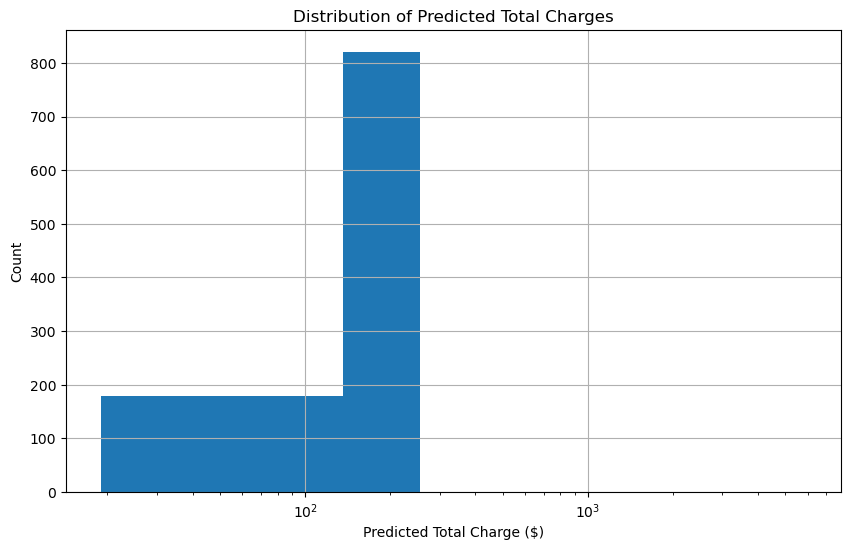

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score, accuracy_score, classification_report
from sklearn.model_selection import train_test_split, RandomizedSearchCV, cross_val_score
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer, KNNImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PowerTransformer
from sklearn.ensemble import HistGradientBoostingClassifier, HistGradientBoostingRegressor
from catboost import CatBoostRegressor, CatBoostClassifier, Pool
import seaborn as sns
from scipy.stats import yeojohnson

# --- Feature Engineering ---
def engineer_features(df, binary_cols, categorical_cols):
    """Create domain-specific features for healthcare costs"""
    df_proc = df.copy()
    
    # Clean binary columns with better handling
    for col in binary_cols:
        df_proc[col] = pd.to_numeric(df_proc[col], errors='coerce')
        # Use 3-way mapping: Yes(1), No(0), Unknown(NaN)
        df_proc[col] = df_proc[col].map({1.0: 1, 2.0: 0})
    
    # Clean categorical columns
    for col in categorical_cols:
        if col in df_proc.columns:
            df_proc[col] = df_proc[col].fillna('Missing').astype(str)
    
    # Create base complexity metrics
    df_proc['service_complexity'] = df_proc[[
        'LABTEST_M18', 'XRAYS_M18', 'MRI_M18', 'EKG_M18', 'SURGPROC'
    ]].sum(axis=1, min_count=1)
    
    # Imaging complexity (weighted)
    df_proc['imaging_intensity'] = (
        (df_proc['XRAYS_M18'] == 1) * 1 + 
        (df_proc['MRI_M18'] == 1) * 5 + 
        (df_proc['EKG_M18'] == 1) * 2
    )
    
    # Create care complexity indicators
    df_proc['did_any_test'] = (df_proc['service_complexity'] > 0).astype(int)
    df_proc['is_complex_visit'] = ((df_proc['service_complexity'] > 1) & 
                                   (df_proc['SURGPROC'] == 1)).astype(int)
    
    # Insurance type features (if insurance column exists)
    if 'insurance' in df_proc.columns:
        df_proc['is_medicare'] = df_proc['insurance'].str.contains('Medicare', na=False).astype(int)
        df_proc['is_private'] = df_proc['insurance'].str.contains('Private', na=False).astype(int)
        df_proc['is_medicaid'] = df_proc['insurance'].str.contains('Medicaid', na=False).astype(int)
    else:
        df_proc['is_medicare'] = 0
        df_proc['is_private'] = 0
        df_proc['is_medicaid'] = 0
    
    # Specialty and visit type interaction
    if 'DRSPLTY_M18' in df_proc.columns:
        df_proc['specialist_visit'] = ((df_proc['DRSPLTY_M18'] != 'primary care') & 
                                      (df_proc['DRSPLTY_M18'] != 'Missing')).astype(int)
    else:
        df_proc['specialist_visit'] = 0
    
    # Season of visit (potential seasonal patterns)
    if 'OBDATEMM' in df_proc.columns:
        df_proc['visit_quarter'] = pd.to_numeric(df_proc['OBDATEMM'], errors='coerce')
        df_proc['visit_quarter'] = df_proc['visit_quarter'].apply(
            lambda x: (x-1)//3 + 1 if not pd.isna(x) else np.nan
        )
    else:
        df_proc['visit_quarter'] = np.nan
    
    # Create telehealth flag with better handling
    df_proc['is_telehealth'] = df_proc['TELEHEALTHFLAG'].fillna(0)
    
    return df_proc

# --- Model Training Functions ---
def train_cost_predictor(df, feature_cols, target_col='total_charge', 
                         use_multimodel=True, transform_method='log'):
    """Train a comprehensive cost prediction model"""
    # Make a copy
    df_model = df.copy()
    
    # Transform target using specified method
    if transform_method == 'log':
        df_model[f'transformed_{target_col}'] = np.log1p(df_model[target_col])
    elif transform_method == 'yeojohnson':
        df_model[f'transformed_{target_col}'], _ = yeojohnson(df_model[target_col])
    else:
        df_model[f'transformed_{target_col}'] = df_model[target_col]
    
    # Determine cost categories
    high_cost_cutoff = df_model[target_col].quantile(0.90)
    medium_cost_cutoff = df_model[target_col].quantile(0.75)
    df_model['cost_category'] = pd.cut(
        df_model[target_col], 
        bins=[0, medium_cost_cutoff, high_cost_cutoff, float('inf')],
        labels=['low', 'medium', 'high']
    )
    
    # For classification model
    df_model['high_cost_flag'] = (df_model[target_col] > high_cost_cutoff).astype(int)
    
    # Prepare features and targets
    feature_set = []
    for col in feature_cols:
        if col in df_model.columns:
            feature_set.append(col)
            
    # Add engineered features
    engineered_features = [
        'service_complexity', 'imaging_intensity', 'did_any_test', 
        'is_complex_visit', 'is_medicare', 'is_private', 'is_medicaid',
        'specialist_visit', 'visit_quarter', 'is_telehealth'
    ]
    
    for feat in engineered_features:
        if feat in df_model.columns:
            feature_set.append(feat)
    
    # Remove features with too many missing values
    valid_features = []
    for col in feature_set:
        if col in df_model.columns and df_model[col].isna().mean() < 0.5:
            valid_features.append(col)
    
    print(f"Using {len(valid_features)} features: {valid_features[:5]}...")
    
    X = df_model[valid_features]
    y = df_model[f'transformed_{target_col}']
    y_raw = df_model[target_col]
    y_class = df_model['high_cost_flag']
    
    # Split data
    X_train, X_test, y_train, y_test, y_raw_train, y_raw_test, y_class_train, y_class_test = train_test_split(
        X, y, y_raw, y_class, test_size=0.2, random_state=42
    )
    
    # Identify categorical features for proper encoding
    categorical_features = list(X.select_dtypes(include=['object', 'category']).columns)
    numeric_features = list(set(X.columns) - set(categorical_features))
    
    print(f"Categorical features: {len(categorical_features)}, Numeric features: {len(numeric_features)}")
    
    # Set up preprocessing
    cat_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='constant', fill_value='Missing')),
        ('encoder', OneHotEncoder(handle_unknown='ignore', sparse_output=False))
    ])
    
    num_transformer = Pipeline([
        ('imputer', SimpleImputer(strategy='median')),  # KNNImputer can be slow on large datasets
        ('scaler', StandardScaler())
    ])
    
    preprocessor = ColumnTransformer([
        ('cat', cat_transformer, categorical_features),
        ('num', num_transformer, numeric_features)
    ])
    
    # Use multi-model approach if specified
    if use_multimodel:
        print("\n--- Training High-Cost Classifier ---")
        # First - Classification stage
        clf_pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('classifier', CatBoostClassifier(
                iterations=500,
                learning_rate=0.05,
                depth=6,
                loss_function='Logloss',
                verbose=0
            ))
        ])
        
        clf_pipeline.fit(X_train, y_class_train)
        
        # Evaluate classifier
        y_class_pred = clf_pipeline.predict(X_test)
        class_acc = accuracy_score(y_class_test, y_class_pred)
        print(f"Classifier accuracy: {class_acc:.4f}")
        print(classification_report(y_class_test, y_class_pred))
        
        # Group-specific models
        models = {}
        metrics = {}
        
        # Define modified preprocessor for each cost group model
        # This ensures consistent preprocessing across all models
        modified_preprocessor = preprocessor.fit(X)
        
        for cost_group in ['low', 'medium', 'high']:
            print(f"\n--- Training {cost_group.upper()} Cost Group Model ---")
            
            # Filter data for this cost group
            if cost_group == 'high':
                mask_train = (y_class_train == 1)
                mask_test = (y_class_test == 1)
            elif cost_group == 'medium':
                mask_train = ((y_raw_train > medium_cost_cutoff) & (y_raw_train <= high_cost_cutoff))
                mask_test = ((y_raw_test > medium_cost_cutoff) & (y_raw_test <= high_cost_cutoff))
            else:  # low
                mask_train = (y_raw_train <= medium_cost_cutoff)
                mask_test = (y_raw_test <= medium_cost_cutoff)
                
            # Skip if not enough samples
            if sum(mask_train) < 100:
                print(f"  Skipping {cost_group} - insufficient samples ({sum(mask_train)})")
                continue
                
            X_group_train = X_train[mask_train].copy()
            y_group_train = y_train[mask_train]
            X_group_test = X_test[mask_test].copy()
            y_group_test = y_test[mask_test]
            y_raw_group_test = y_raw_test[mask_test]
            
            # DO NOT add classifier probability as feature since it uses different preprocessing
            # and would cause feature mismatch errors
            
            # Train cost predictor for this group
            reg_pipeline = Pipeline([
                ('preprocessor', modified_preprocessor),
                ('regressor', CatBoostRegressor(
                    iterations=1000,
                    learning_rate=0.03,
                    depth=5,
                    loss_function='RMSE',
                    verbose=0
                ))
            ])
            
            # Fit and evaluate
            reg_pipeline.fit(X_group_train, y_group_train)
            
            # Make predictions
            y_pred_transformed = reg_pipeline.predict(X_group_test)
            
            # Inverse transform predictions
            if transform_method == 'log':
                y_pred = np.expm1(y_pred_transformed)
            else:
                y_pred = y_pred_transformed  # Simplified for other methods
                
            # Calculate metrics
            rmse = np.sqrt(mean_squared_error(y_raw_group_test, y_pred))
            r2 = r2_score(y_raw_group_test, y_pred)
            
            print(f"  Group size: {len(y_group_test)} samples")
            print(f"  RMSE: {rmse:.2f}, R²: {r2:.4f}")
            
            # Store model and metrics
            models[cost_group] = reg_pipeline
            metrics[cost_group] = {
                'rmse': rmse,
                'r2': r2,
                'samples': len(y_group_test)
            }
        
        # Also train a global fallback model
        print("\n--- Training Global Fallback Model ---")
        global_pipeline = Pipeline([
            ('preprocessor', modified_preprocessor),
            ('regressor', CatBoostRegressor(
                iterations=1000,
                learning_rate=0.05,
                depth=6,
                loss_function='RMSE',
                verbose=0
            ))
        ])
        
        global_pipeline.fit(X_train, y_train)
        
        # Add to models
        models['global'] = global_pipeline
        
        # Evaluate global model
        y_pred_transformed = global_pipeline.predict(X_test)
        if transform_method == 'log':
            y_pred = np.expm1(y_pred_transformed)
        else:
            y_pred = y_pred_transformed
            
        rmse = np.sqrt(mean_squared_error(y_raw_test, y_pred))
        r2 = r2_score(y_raw_test, y_pred)
        
        print(f"  Global model RMSE: {rmse:.2f}, R²: {r2:.4f}")
        
        metrics['global'] = {
            'rmse': rmse,
            'r2': r2,
            'samples': len(y_test)
        }
        
        # Return the classifier, models and metrics
        return {
            'classifier': clf_pipeline,
            'regressor_models': models,
            'metrics': metrics,
            'preprocessor': modified_preprocessor,
            'transform_method': transform_method,
            'thresholds': {
                'high': high_cost_cutoff,
                'medium': medium_cost_cutoff
            },
            'features': valid_features
        }
    
    else:
        # Standard single model approach
        print("\n--- Training Single Global Model ---")
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ('regressor', CatBoostRegressor(
                iterations=1000,
                learning_rate=0.05,
                depth=6,
                loss_function='RMSE',
                verbose=0
            ))
        ])
        
        pipeline.fit(X_train, y_train)
        
        # Evaluate
        y_pred_transformed = pipeline.predict(X_test)
        if transform_method == 'log':
            y_pred = np.expm1(y_pred_transformed)
        else:
            y_pred = y_pred_transformed
            
        rmse = np.sqrt(mean_squared_error(y_raw_test, y_pred))
        r2 = r2_score(y_raw_test, y_pred)
        
        print(f"Single model RMSE: {rmse:.2f}, R²: {r2:.4f}")
        
        return {
            'regressor': pipeline,
            'metrics': {
                'rmse': rmse,
                'r2': r2
            },
            'transform_method': transform_method,
            'features': valid_features
        }

# --- Main Execution ---
def main():
    # Define columns
    feature_cols = [
        'VISITTYPE', 'VSTCTGRY', 'DOCATLOC', 'DRSPLTY_M18',
        'MEDPTYPE_M18', 'SEEDOC_M18', 'SURGPROC', 'MEDPRESC', 'TELEHEALTHFLAG',
        'LABTEST_M18', 'XRAYS_M18', 'MRI_M18', 'EKG_M18',
        'OBDATEYR', 'OBDATEMM', 'insurance'
    ]

    binary_cols = [
        'DOCATLOC', 'SEEDOC_M18', 'SURGPROC', 'MEDPRESC', 'TELEHEALTHFLAG', 
        'LABTEST_M18', 'XRAYS_M18', 'MRI_M18', 'EKG_M18'
    ]
    
    categorical_cols = list(set(feature_cols) - set(binary_cols))
    
    # Engineer features
    df_processed = engineer_features(df, binary_cols, categorical_cols)
    
    # Filter out rows with missing targets
    df_model = df_processed[~df_processed['total_charge'].isna()].copy()
    print(f"Working with {len(df_model)} rows with valid total charge values")
    
    # Train models
    model_package = train_cost_predictor(
        df_model, 
        feature_cols, 
        target_col='total_charge',
        use_multimodel=True, 
        transform_method='log'
    )
    
    # Print summary of results
    print("\n=== Model Performance Summary ===")
    if 'regressor_models' in model_package:
        metrics = model_package['metrics']
        for model_type, metric in metrics.items():
            print(f"{model_type.upper()}: RMSE={metric['rmse']:.2f}, R²={metric['r2']:.4f} (n={metric['samples']})")
    else:
        print(f"Single model: RMSE={model_package['metrics']['rmse']:.2f}, R²={model_package['metrics']['r2']:.4f}")

    # Optional: Use model to make predictions on test data
    # Showing how to use the model package for predictions
    X_test_sample = df_model.sample(1000)[model_package['features']]
    
    # Create predictions depending on model type
    if 'regressor_models' in model_package:
        # Multi-model approach
        classifier = model_package['classifier']
        models = model_package['regressor_models']
        transform_method = model_package['transform_method']
        
        # Get predicted class
        high_cost_proba = classifier.predict_proba(X_test_sample)[:, 1]
        high_cost_flag = (high_cost_proba >= 0.5).astype(int)
        
        # Get predictions from appropriate model
        predictions = []
        for i, flag in enumerate(high_cost_flag):
            if flag == 1:
                model_to_use = models['high']
            else:
                value = X_test_sample.iloc[i:i+1]['total_charge'].values[0] if 'total_charge' in X_test_sample.columns else 0
                if value > model_package['thresholds']['medium']:
                    model_to_use = models['medium']
                else:
                    model_to_use = models['low']
                    
            # Make prediction
            predicted_transform = model_to_use.predict(X_test_sample.iloc[i:i+1])[0]
            
            # Untransform
            if transform_method == 'log':
                predictions.append(np.expm1(predicted_transform))
            else:
                predictions.append(predicted_transform)
    else:
        # Single model approach
        predictions = model_package['regressor'].predict(X_test_sample)
        if model_package['transform_method'] == 'log':
            predictions = np.expm1(predictions)
    
    # Show distribution of predictions
    plt.figure(figsize=(10, 6))
    plt.hist(predictions, bins=50)
    plt.title('Distribution of Predicted Total Charges')
    plt.xlabel('Predicted Total Charge ($)')
    plt.ylabel('Count')
    plt.xscale('log')
    plt.grid(True)
    plt.show()

if __name__ == "__main__":
    main()

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, r2_score
from catboost import CatBoostRegressor, Pool
from scipy.stats.mstats import winsorize

# --- Feature Setup ---
feature_cols = [
    'VISITTYPE', 'VSTCTGRY', 'DOCATLOC', 'DRSPLTY_M18',
    'MEDPTYPE_M18', 'SEEDOC_M18', 'SURGPROC', 'MEDPRESC', 'TELEHEALTHFLAG',
    'LABTEST_M18', 'XRAYS_M18', 'MRI_M18', 'EKG_M18',
    'OBDATEYR', 'OBDATEMM', 'insurance'
]

binary_cols = [
    'DOCATLOC', 'SEEDOC_M18', 'SURGPROC', 'MEDPRESC', 'TELEHEALTHFLAG', 
    'LABTEST_M18', 'XRAYS_M18', 'MRI_M18', 'EKG_M18'
]

# --- Filter subgroup ---
df_filtered = df[df['insurance'] == '65+ Medicare + Private'].copy()

# --- Clean binary columns ---
for col in binary_cols:
    df_filtered[col] = pd.to_numeric(df_filtered[col], errors='coerce')
    df_filtered[col] = df_filtered[col].map({1.0: 1, 2.0: 0})

# --- Clean categorical columns ---
categorical_cols = list(set(feature_cols) - set(binary_cols))
df_filtered[categorical_cols] = df_filtered[categorical_cols].fillna('Missing').astype(str)

# --- Filter missing targets only ---
df_filtered = df_filtered[~df_filtered['total_charge'].isna()]
print(f"✅ Rows after dropping missing targets: {len(df_filtered)}")

# --- Domain-informed features ---
df_filtered['num_services'] = df_filtered[
    ['LABTEST_M18', 'XRAYS_M18', 'MRI_M18', 'EKG_M18']
].sum(axis=1)
df_filtered['did_any_test'] = (df_filtered['num_services'] > 0).astype(int)

# --- Winsorize and transform target ---
df_filtered['total_charge'] = winsorize(df_filtered['total_charge'], limits=[0.01, 0.01])
df_filtered['log_total_charge'] = np.log1p(df_filtered['total_charge'])

# --- Add weights for high-cost cases ---
high_cost_cutoff = df_filtered['total_charge'].quantile(0.95)
df_filtered['weight'] = np.where(df_filtered['total_charge'] > high_cost_cutoff, 5, 1)

# --- Final setup ---
X = df_filtered[feature_cols + ['num_services', 'did_any_test']]
y = df_filtered['log_total_charge']
weights = df_filtered['weight']
cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype == 'object']

# --- Train CatBoost ---
train_pool = Pool(X, y, cat_features=cat_features, weight=weights)
model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='Quantile:alpha=0.5',  # more robust to outliers
    verbose=100
)
model.fit(train_pool)

# --- Predict ---
y_pred_log = model.predict(X)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y)

# --- Evaluate ---
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
print(f"\n📊 Final RMSE: {rmse:.2f}, R²: {r2:.4f}")

# --- Evaluate on high-cost ---
mask_high_cost = y_true > high_cost_cutoff
rmse_high = np.sqrt(mean_squared_error(y_true[mask_high_cost], y_pred[mask_high_cost]))
r2_high = r2_score(y_true[mask_high_cost], y_pred[mask_high_cost])
print(f"📊 High-Cost (95th percentile+) RMSE: {rmse_high:.2f}, R²: {r2_high:.4f}")

# --- Feature importances ---
importance = model.get_feature_importance(prettified=True)
print("\n🔑 Top 10 Important Features:")
display(importance.head(10))

# --- Plot predictions ---
plt.figure(figsize=(8, 5))
plt.hist(y_pred, bins=100)
plt.title('Predicted Total Charges (Raw Scale)')
plt.xlabel('Total Charge ($)')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()


CAT BOOST IMPLEMENTATION

In [ ]:
!pip install catboost
!pip install scipy

In [ ]:
print(df[df['insurance'] == '65+ Medicare + Private'])

In [ ]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score
from scipy.stats.mstats import winsorize
from catboost import CatBoostRegressor, Pool

# --- Feature Columns ---
feature_cols = [
    'VISITTYPE', 'VSTCTGRY', 'DOCATLOC', 'DRSPLTY_M18',
    'MEDPTYPE_M18', 'SEEDOC_M18', 'SURGPROC', 'MEDPRESC', 'TELEHEALTHFLAG',
    'LABTEST_M18', 'XRAYS_M18', 'MRI_M18', 'EKG_M18',
    'OBDATEYR', 'OBDATEMM', 'insurance'
]

binary_cols = [
    'DOCATLOC', 'SEEDOC_M18', 'SURGPROC', 'MEDPRESC', 'TELEHEALTHFLAG', 
    'LABTEST_M18', 'XRAYS_M18', 'MRI_M18', 'EKG_M18'
]

# --- Filter to subgroup ---
df_filtered = df[df['insurance'] == '65+ Medicare + Private'].copy()

# --- Clean binary ---
for col in binary_cols:
    df_filtered[col] = pd.to_numeric(df_filtered[col], errors='coerce')
    df_filtered[col] = df_filtered[col].map({1.0: 1, 2.0: 0})

# --- Handle categorical vars ---
categorical_cols = list(set(feature_cols) - set(binary_cols))
df_filtered[categorical_cols] = df_filtered[categorical_cols].fillna('Missing').astype(str)

# --- Drop missing targets only ---
df_filtered = df_filtered[~df_filtered['total_charge'].isna()]
print(f"✅ Rows after dropping missing targets: {len(df_filtered)}")

# --- Winsorize and log transform ---
df_filtered['total_charge'] = winsorize(df_filtered['total_charge'], limits=[0.01, 0.01])
df_filtered['log_total_charge'] = np.log1p(df_filtered['total_charge'])

# --- Weight high-cost patients heavier ---
df_filtered['weight'] = np.where(
    df_filtered['total_charge'] > df_filtered['total_charge'].quantile(0.95), 10, 1
)

# --- Define X, y, weights ---
X = df_filtered[feature_cols]
y = df_filtered['log_total_charge']
weights = df_filtered['weight']

# --- Train/Test Split ---
X_train, X_test, y_train, y_test, w_train, w_test = train_test_split(
    X, y, weights, test_size=0.2, random_state=42
)

# --- Categorical indices for CatBoost ---
cat_features = [i for i, col in enumerate(X.columns) if X[col].dtype == 'object']

# --- Train Pool ---
train_pool = Pool(X_train, y_train, cat_features=cat_features, weight=w_train)
test_pool = Pool(X_test, y_test, cat_features=cat_features)

# --- Train Model ---
model = CatBoostRegressor(
    iterations=500,
    learning_rate=0.05,
    depth=6,
    loss_function='MAE',  # Consider 'Quantile:alpha=0.5' for robustness
    verbose=100
)
model.fit(train_pool)

# --- Predict ---
y_pred_log = model.predict(X_test)
y_pred = np.expm1(y_pred_log)
y_true = np.expm1(y_test)

# --- Overall Evaluation ---
rmse = np.sqrt(mean_squared_error(y_true, y_pred))
r2 = r2_score(y_true, y_pred)
print(f"\n📊 Final RMSE: {rmse:.2f}, R²: {r2:.4f}")

# --- High-Cost Evaluation ---
cutoff = df_filtered['total_charge'].quantile(0.95)
mask_high = y_true > cutoff
rmse_high = np.sqrt(mean_squared_error(y_true[mask_high], y_pred[mask_high]))
r2_high = r2_score(y_true[mask_high], y_pred[mask_high])
print(f"📊 High-Cost (95th percentile+) RMSE: {rmse_high:.2f}, R²: {r2_high:.4f}")

# --- Feature Importance ---
importance = model.get_feature_importance(prettified=True)
print("\n🔑 Top 10 Important Features:")
display(importance.head(10))

# --- Plot Predicted Charges ---
plt.figure(figsize=(8, 5))
plt.hist(y_pred, bins=100)
plt.title('Predicted Total Charges')
plt.xlabel('Total Charge ($)')
plt.ylabel('Frequency')
plt.yscale('log')
plt.show()


In [ ]:
def remove_target_outliers(X, y, std_dev=3):
    """Remove extreme values from target variable"""
    mean = y.mean()
    std = y.std()
    mask = (y > mean - std_dev * std) & (y < mean + std_dev * std)
    
    print(f"Removing {(~mask).sum()} outliers from {len(y)} samples ({(~mask).sum()/len(y)*100:.2f}%)")
    
    return X[mask], y[mask]

In [ ]:
for target_name, y in targets.items():
    print(f"\n Prediction: {target_name}")
    start_target = time.time()

    # Combine features and actual target column (y is a Series with the correct column)
    df_model = pd.concat([X, y], axis=1)
    #df_with_na = df_model[df_model.isna().any(axis=1)]
    #print(df_with_na)
    #num_na_rows = df_model.isna().any(axis=1).sum()
    #print(f"{num_na_rows} rows contain at least one NA value.")
    df_model = df_model.dropna()



    X_clean = df_model[feature_cols]
    y_clean = df_model[y.name]  # Get actual column name from Series

    X_train, X_test, y_train, y_test = train_test_split(
        X_clean, y_clean, test_size=0.2, random_state=42
    )

    for model_name, model in models.items():
    #for model_name, model in tqdm(models.items(), desc=f"Models for {target_name}", leave=False):
        start_model = time.time()
        pipe = Pipeline(steps=[
            ('preprocessor', preprocessor),
            ('model', model)
        ])

        pipe.fit(X_train, y_train)
        y_pred = pipe.predict(X_test)

        rmse = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)

        #print(f"{model_name:20} | RMSE: {rmse:8.2f} | R²: {r2:.4f}")
        duration = time.time() - start_model
        print(f"{model_name} done in {duration:.2f}s | RMSE: {rmse:.2f}, R²: {r2:.4f}")

    print(f"✅ Finished {target_name} in {time.time() - start_target:.2f}s")


In [ ]:
targets['Cost Covered'] = targets['Cost Covered'].clip(lower=0)

log_targets = {
    'Log Total Cost': np.log1p(targets['Total Cost']),
    'Log Out-of-Pocket': np.log1p(targets['Out-of-Pocket']),
    'Log Cost Covered': np.log1p(targets['Cost Covered'])
}

cost_types = ['Total Cost', 'Out-of-Pocket', 'Cost Covered']
importance_by_cost = {}

# Check for NaN or infinite values after log transformation
for target_name, y in log_targets.items():
    nan_count = y.isna().sum()
    inf_count = np.isinf(y).sum()
    print(f"{target_name}: {nan_count} NaNs, {inf_count} infinities")
    
    # Replace infinities with NaNs, then drop rows with NaNs
    log_targets[target_name] = y.replace([np.inf, -np.inf], np.nan)

# Modified training code with better error handling
for target_name, y in log_targets.items():
    print(f"\nPrediction: {target_name}")
    start_target = time.time()

    # Combine features and actual target column
    df_model = pd.concat([X, y], axis=1)
    df_model = df_model.dropna()  # Drop any rows with NaN values
    
    # Safety check - are there enough rows?
    if len(df_model) < 100:  # arbitrary threshold
        print(f"Warning: Only {len(df_model)} valid rows for {target_name}")
        continue

    # Check if any zeros in original data created -inf in log data
    if (y == -np.inf).any():
        print(f"Warning: {target_name} contains -inf values from log(0)")

    X_clean = df_model[feature_cols]
    y_clean = df_model[y.name]  # Get actual column name from Series
    X_clean, y_clean = remove_target_outliers(X_clean, y_clean, std_dev=3)
    X_train, X_test, y_train, y_test = train_test_split(
        X_clean, y_clean, test_size=0.2, random_state=42
    )

    try:
        for model_name, model in models.items():
            start_model = time.time()
            pipe = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('model', model)
            ])

            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_test)

            # Calculate metrics on transformed scale
            rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))
            r2_log = r2_score(y_test, y_pred)
            
            # Try to calculate original scale metrics, but handle errors
            try:
                y_test_original = np.expm1(y_test)
                y_pred_original = np.expm1(y_pred)
                rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
                r2_original = r2_score(y_test_original, y_pred_original)
                duration = time.time() - start_model
                print(f"{model_name} done in {duration:.2f}s")
                print(f"  Log scale - RMSE: {rmse_log:.4f}, R²: {r2_log:.4f}")
                print(f"  Original scale - RMSE: {rmse_original:.2f}, R²: {r2_original:.4f}")
            except:
                print(f"{model_name} done in {duration:.2f}s")
                print(f"  Log scale - RMSE: {rmse_log:.4f}, R²: {r2_log:.4f}")
                print(f"  Original scale metrics calculation failed")
    
    except Exception as e:
        print(f"Error training model for {target_name}: {str(e)}")

    print(f"✅ Finished {target_name} in {time.time() - start_target:.2f}s")

baseline = y_test.mean()
print(f"Baseline RMSE: {np.sqrt(mean_squared_error(y_test, [baseline] * len(y_test))):.2f}")


In [ ]:
#FEATURE IMPORTANCE


def get_feature_names_from_preprocessor(preprocessor):
    """Extract feature names from the preprocessor pipeline"""
    feature_names = []
    
    # Handle different types of preprocessors
    if hasattr(preprocessor, 'get_feature_names_out'):
        # For newer scikit-learn versions
        feature_names = preprocessor.get_feature_names_out()
    elif hasattr(preprocessor, 'get_feature_names'):
        # For older scikit-learn versions
        feature_names = preprocessor.get_feature_names()
    else:
        # For custom preprocessors, try to extract from transformers
        try:
            for name, transformer, columns in preprocessor.transformers_:
                if hasattr(transformer, 'get_feature_names_out'):
                    trans_features = transformer.get_feature_names_out()
                elif hasattr(transformer, 'get_feature_names'):
                    trans_features = transformer.get_feature_names()
                else:
                    trans_features = columns
                feature_names.extend(trans_features)
        except:
            # Fallback to numbered features
            feature_names = [f'feature_{i}' for i in range(preprocessor.transform(X_train.iloc[:1]).shape[1])]
    
    return feature_names


# Add feature importance analysis after model fitting
for target_name, y in log_targets.items():
    print(f"\nPrediction: {target_name}")
    start_target = time.time()

    # Combine features and actual target column
    df_model = pd.concat([X, y], axis=1)
    df_model = df_model.dropna()  # Drop any rows with NaN values
    
    # Safety check - are there enough rows?
    if len(df_model) < 100:  # arbitrary threshold
        print(f"Warning: Only {len(df_model)} valid rows for {target_name}")
        continue

    # Check if any zeros in original data created -inf in log data
    if (y == -np.inf).any():
        print(f"Warning: {target_name} contains -inf values from log(0)")

    X_clean = df_model[feature_cols]
    y_clean = df_model[y.name]  # Get actual column name from Series
    X_clean, y_clean = remove_target_outliers(X_clean, y_clean, std_dev=3)
    X_train, X_test, y_train, y_test = train_test_split(
        X_clean, y_clean, test_size=0.2, random_state=42
    )

    # Store feature importances for this cost type
    cost_type = target_name.replace('Log ', '')
    importance_by_cost[cost_type] = {}

    try:
        for model_name, model in models.items():
            start_model = time.time()
            pipe = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('model', model)
            ])

            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_test)

            # Calculate metrics on transformed scale
            rmse_log = np.sqrt(mean_squared_error(y_test, y_pred))
            r2_log = r2_score(y_test, y_pred)
            
            # Try to calculate original scale metrics, but handle errors
            try:
                y_test_original = np.expm1(y_test)
                y_pred_original = np.expm1(y_pred)
                rmse_original = np.sqrt(mean_squared_error(y_test_original, y_pred_original))
                r2_original = r2_score(y_test_original, y_pred_original)
                
                duration = time.time() - start_model  # Fix: Added this line to calculate duration
                
                print(f"{model_name} done in {duration:.2f}s")
                print(f"  Log scale - RMSE: {rmse_log:.4f}, R²: {r2_log:.4f}")
                print(f"  Original scale - RMSE: {rmse_original:.2f}, R²: {r2_original:.4f}")
            except Exception as e:
                duration = time.time() - start_model  # Fix: Added this line to calculate duration
                print(f"{model_name} done in {duration:.2f}s")
                print(f"  Log scale - RMSE: {rmse_log:.4f}, R²: {r2_log:.4f}")
                print(f"  Original scale metrics calculation failed: {str(e)}")
            
            # Extract feature importances if model supports it
            if hasattr(model, 'feature_importances_') or (hasattr(model, 'coef_')):
                feature_names = get_feature_names_from_preprocessor(preprocessor)
                
                # Get feature importances based on model type
                if model_name in ['RandomForest', 'GradientBoosting', 'XGBoost']:
                    # For tree-based models
                    feature_importances = pipe.named_steps['model'].feature_importances_
                elif model_name in ['Linear', 'Ridge', 'Lasso']:
                    # For linear models
                    feature_importances = np.abs(pipe.named_steps['model'].coef_)
                else:
                    print(f"Feature importance not implemented for {model_name}")
                    continue
                
                # Create a DataFrame with feature names and importances
                if len(feature_names) == len(feature_importances):
                    importance_df = pd.DataFrame({
                        'Feature': feature_names,
                        'Importance': feature_importances
                    }).sort_values('Importance', ascending=False)
                    
                    # Store top features for this model and cost type
                    importance_by_cost[cost_type][model_name] = importance_df.head(10)
                    
                    # Print top 5 features
                    print(f"  Top 5 important features for {model_name}:")
                    for i, (feature, importance) in enumerate(zip(importance_df['Feature'].head(5), 
                                                                 importance_df['Importance'].head(5))):
                        print(f"    {i+1}. {feature}: {importance:.4f}")
                else:
                    print(f"  Feature names and importances length mismatch: {len(feature_names)} vs {len(feature_importances)}")
    
    except Exception as e:
        print(f"Error training model for {target_name}: {str(e)}")

    print(f"✅ Finished {target_name} in {time.time() - start_target:.2f}s")

# Now visualize feature importances across models and cost types
for cost_type, model_importances in importance_by_cost.items():
    print(f"\n=== Feature Importance for {cost_type} ===")
    
    # Combine importances from different models
    if len(model_importances) > 0:
        # Aggregate feature importances across models
        all_features = set()
        for model_name, importance_df in model_importances.items():
            all_features.update(importance_df['Feature'].tolist())
        
        # Create a summary DataFrame showing top features across multiple models
        summary_df = pd.DataFrame(index=list(all_features), columns=model_importances.keys())
        
        for model_name, importance_df in model_importances.items():
            for _, row in importance_df.iterrows():
                summary_df.loc[row['Feature'], model_name] = row['Importance']
        
        # Fill NaN values with 0
        summary_df = summary_df.fillna(0)
        
        # Add average importance across models
        summary_df['Average'] = summary_df.mean(axis=1)
        
        # Sort by average importance
        summary_df = summary_df.sort_values('Average', ascending=False)
        
        # Print top 10 features by average importance
        print("Top 10 features by average importance:")
        print(summary_df.head(10))
    else:
        print("No feature importances available for this cost type")

In [ ]:
# Add this after your model training loop to create prediction vs actual visualizations

import matplotlib.pyplot as plt
from matplotlib.ticker import FuncFormatter
import seaborn as sns
import matplotlib.gridspec as gridspec

# Dictionary to store predictions for visualization
predictions_by_cost = {}

# Modify your model training loop to store predictions
for target_name, y in log_targets.items():
    print(f"\nPrediction: {target_name}")
    start_target = time.time()
    
    # (Keep your existing data preparation code)
    df_model = pd.concat([X, y], axis=1)
    df_model = df_model.dropna()
    
    if len(df_model) < 100:
        print(f"Warning: Only {len(df_model)} valid rows for {target_name}")
        continue
        
    # (Keep your existing code for checking -inf values, cleaning data and train/test split)
    if (y == -np.inf).any():
        print(f"Warning: {target_name} contains -inf values from log(0)")

    X_clean = df_model[feature_cols]
    y_clean = df_model[y.name]
    X_clean, y_clean = remove_target_outliers(X_clean, y_clean, std_dev=3)
    X_train, X_test, y_train, y_test = train_test_split(
        X_clean, y_clean, test_size=0.2, random_state=42
    )
    
    # Store the predictions for this cost type
    cost_type = target_name.replace('Log ', '')
    predictions_by_cost[cost_type] = {'actual': np.expm1(y_test)}
    
    try:
        for model_name, model in models.items():
            # (Keep your existing model fitting code)
            start_model = time.time()
            pipe = Pipeline(steps=[
                ('preprocessor', preprocessor),
                ('model', model)
            ])

            pipe.fit(X_train, y_train)
            y_pred = pipe.predict(X_test)
            
            # Store predictions for visualization
            predictions_by_cost[cost_type][f'{model_name}_pred'] = np.expm1(y_pred)
            
            # (Keep your existing metrics calculation code)
            
    except Exception as e:
        print(f"Error training model for {target_name}: {str(e)}")

# Create prediction vs actual plots
def currency_formatter(x, pos):
    """Format numbers as currency with K for thousands, M for millions"""
    if x >= 1e6:
        return f'${x/1e6:.1f}M'
    elif x >= 1e3:
        return f'${x/1e3:.1f}K'
    else:
        return f'${x:.0f}'

# Create a figure for each cost type
for cost_type, predictions in predictions_by_cost.items():
    actual_values = predictions['actual']
    
    # Get the number of models
    model_names = [key.replace('_pred', '') for key in predictions.keys() if key != 'actual']
    n_models = len(model_names)
    
    if n_models == 0:
        continue
    
    # Create a figure with subplots
    fig = plt.figure(figsize=(15, 4 * ((n_models + 1) // 2)))
    gs = gridspec.GridSpec(((n_models + 1) // 2), 2)
    
    # Add title to the figure
    fig.suptitle(f'Predicted vs Actual: {cost_type}', fontsize=16, y=0.98)
    
    for i, model_name in enumerate(model_names):
        ax = plt.subplot(gs[i // 2, i % 2])
        predicted_values = predictions[f'{model_name}_pred']
        
        # Create scatter plot
        ax.scatter(actual_values, predicted_values, alpha=0.5, s=20)
        
        # Add diagonal line representing perfect prediction
        max_val = max(actual_values.max(), predicted_values.max())
        min_val = min(actual_values.min(), predicted_values.min())
        ax.plot([min_val, max_val], [min_val, max_val], 'r--')
        
        # Add correlation coefficient
        corr = np.corrcoef(actual_values, predicted_values)[0, 1]
        rmse = np.sqrt(mean_squared_error(actual_values, predicted_values))
        
        # Set titles and labels
        ax.set_title(f'{model_name} (r = {corr:.3f}, RMSE = {rmse:.2f})')
        ax.set_xlabel('Actual Values')
        ax.set_ylabel('Predicted Values')
        
        # Format axes as currency
        ax.xaxis.set_major_formatter(FuncFormatter(currency_formatter))
        ax.yaxis.set_major_formatter(FuncFormatter(currency_formatter))
        
        # Add grid
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'{cost_type}_predictions.png', dpi=300)
    plt.show()

# Generate residual plots to show prediction error
for cost_type, predictions in predictions_by_cost.items():
    actual_values = predictions['actual']
    
    # Get the number of models
    model_names = [key.replace('_pred', '') for key in predictions.keys() if key != 'actual']
    n_models = len(model_names)
    
    if n_models == 0:
        continue
    
    # Create a figure with subplots
    fig = plt.figure(figsize=(15, 4 * ((n_models + 1) // 2)))
    gs = gridspec.GridSpec(((n_models + 1) // 2), 2)
    
    # Add title to the figure
    fig.suptitle(f'Residual Analysis: {cost_type}', fontsize=16, y=0.98)
    
    for i, model_name in enumerate(model_names):
        ax = plt.subplot(gs[i // 2, i % 2])
        predicted_values = predictions[f'{model_name}_pred']
        residuals = actual_values - predicted_values
        
        # Create residual plot
        ax.scatter(predicted_values, residuals, alpha=0.5, s=20)
        
        # Add horizontal line at y=0
        ax.axhline(y=0, color='r', linestyle='--')
        
        # Set titles and labels
        ax.set_title(f'{model_name} Residuals')
        ax.set_xlabel('Predicted Values')
        ax.set_ylabel('Residuals (Actual - Predicted)')
        
        # Format x-axis as currency
        ax.xaxis.set_major_formatter(FuncFormatter(currency_formatter))
        
        # Add grid
        ax.grid(True, alpha=0.3)
    
    plt.tight_layout(rect=[0, 0, 1, 0.95])
    plt.savefig(f'{cost_type}_residuals.png', dpi=300)
    plt.show()